# NODDI-Watson

Zhang et al. [1] proposed a model to estimate the dispersion of neurites (i.e. both axons and neuron dendrites), and is called Neurite Orientation Dispersion and Density Imaging (NODDI). It models dispersion for a single axon bundle using a Watson distribution $W(\kappa,\boldsymbol{\mu})$, that is a particular case of Bingham when $\kappa=\kappa_1=\kappa_2$. As such, it is incapable of modeling axon bending or fanning. The model separately models the CSF, restricted and hindered diffusion as a Gaussian Ball, Stick and Zeppelin model. NODDI models the signal as
\begin{align}
 E^{\textrm{NODDI}}_{\textrm{Watson}}= \underbrace{f_{\textrm{CSF}}\overbrace{E_{\textrm{iso}}(\cdot|\lambda_{\textrm{CSF}})}^{\textrm{Ball}}}_{\textrm{CSF}}
                             +\overbrace{W(\kappa,\boldsymbol{\mu})}^{\textrm{Watson}}\,*_{\mathbb{S}^2}\, \left[\underbrace{f_h\overbrace{E_{\textrm{h}}(\cdot|\lambda_\perp^{\textrm{tort}},\lambda_\parallel)}^{\textrm{Zeppelin}}}_{\textrm{Hindered Extra-Axonal}}+\underbrace{f_r\overbrace{E_r(\cdot|\lambda_\parallel)}^{\textrm{Stick}}}_{\textrm{Intra-Axonal}}\right].
\end{align}
To improve the stability of estimated model parameters, NODDI sets several constraints on model parameters: 
- isotropic diffusivity $\lambda_{\textrm{CSF}}$ is fixed to $3\cdot10^-9 m^2/s$ 
- parallel diffusivity $\lambda_\parallel$ of the stick and zeppelin are the same and fixed to $1.7\cdot10^-9 m^2/s$ 
- A tortuosity model is used to link the perpendicular diffusivity $\lambda_\perp^{\textrm{tort}}$ to the intra- and extra- axonal volume fraction $f_r$, $f_h$ and parallel diffusivity $\lambda_\parallel$.

The only parameters that NODDI-Watson finally fits to the data are Watson parameters $\kappa$, $\mu$ and the volume fractions $f_{\textrm{CSF}}$, $f_h$ and $f_r$.

References:  
[1] Zhang, Hui, et al. "NODDI: practical in vivo neurite orientation dispersion and density imaging of the human brain." Neuroimage 61.4 (2012): 1000-1016.

# Using Mipy to set up the NODDI-Watson model

Setting up the NODDI-Watson model in Mipy is simple.  
First, we instantiate the model components for the non-dispersed components themselves: a Ball for the CSF, and the Stick and Zeppelin for the intra- and extra-axonal diffusion.

In [1]:
from microstruktur.signal_models import cylinder_models, gaussian_models
ball = gaussian_models.G3Ball()
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G4Zeppelin()

Then, we have to set all of NODDI's model parameter links that we listed above.  
Aside from setting the Tortuosy, we must also set $\lambda_\parallel$ to be the same for the Stick and Zeppelin. Setting the diffusivities comes later.

In [2]:
from microstruktur.utils.utils import parameter_equality, T1_tortuosity
watson_bundle_links = [
    (zeppelin, 'lambda_perp', T1_tortuosity, [(stick, 'lambda_par'), (None, 'partial_volume_0')]),
    (zeppelin, 'lambda_par',  parameter_equality,   [(stick, 'lambda_par')])
]

We then Watson-disperse the stick and zeppelin together, making a representation for a dispersed single axon bundle

In [3]:
from microstruktur.distributions.distribute_models import SD1WatsonDistributed
watson_dispersed_bundle = SD1WatsonDistributed(models=[stick, zeppelin],
                                               parameter_links=watson_bundle_links)

Finally, we put the model together with the scheme as follows.

In [4]:
from microstruktur.core.modeling_framework import MultiCompartmentModel
NODDI_mod = MultiCompartmentModel(models=[ball, watson_dispersed_bundle])

You can see the names and cardinality of the to-be optimized parameters in the generated MultiCompartmentModel as follows.

In [5]:
NODDI_mod.parameter_cardinality

OrderedDict([('G3Ball_1_lambda_iso', 1),
             ('SD1WatsonDistributed_1_C1Stick_1_lambda_par', 1),
             ('SD1WatsonDistributed_1_SD1Watson_1_mu', 2),
             ('SD1WatsonDistributed_1_partial_volume_0', 1),
             ('SD1WatsonDistributed_1_SD1Watson_1_odi', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

The last thing is to fix the diffusivities to static values. We can do that using the model.fix_parameter(parameter_name, value) function.

In [6]:
NODDI_mod.fix_parameter('G3Ball_1_lambda_iso', 3e-9)
NODDI_mod.fix_parameter('SD1WatsonDistributed_1_C1Stick_1_lambda_par', 1.7e-9)

Notice how the fixed parameters are now removed from the parameter dictionaries:

In [7]:
NODDI_mod.parameter_cardinality

OrderedDict([('SD1WatsonDistributed_1_SD1Watson_1_mu', 2),
             ('SD1WatsonDistributed_1_partial_volume_0', 1),
             ('SD1WatsonDistributed_1_SD1Watson_1_odi', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

Done!

# Fitting NODDI to Human Connectome Project data

To illustrate Mipy's ease-of-use we also fit the our constructed model to a coronal slice of the HCP data.

In [8]:
from microstruktur.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data originates from Subject 100307 of the WU-Minn Human Connectome Project. View terms of use at https://store.humanconnectome.org/data/data-use-terms/open-access.php


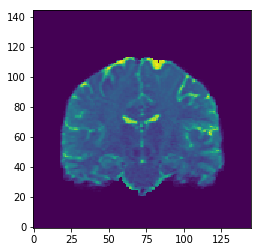

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
# the b0 value of the slice.
plt.imshow(data_hcp[:,0,:,0].T, origin=True)

## Fit NODDI to HCP data

In [10]:
NODDI_fit_hcp = NODDI_mod.fit(
    scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0)

Setup brute2fine optimizer in 7.42221093178 seconds
Fitting of 8181 voxels complete in 1048.78785205 seconds.
Average of 0.128198001717 seconds per voxel.


## Visualize results

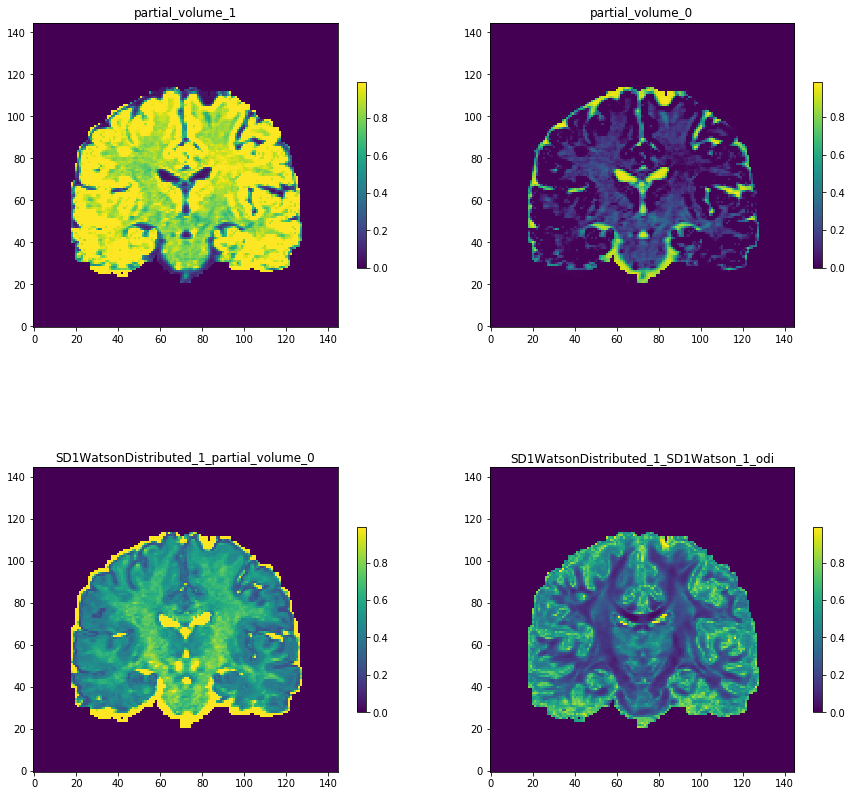

In [11]:
fitted_parameters = NODDI_fit_hcp.fitted_parameters

fig, axs = plt.subplots(2, 2, figsize=[15, 15])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.5)
    counter += 1

Above we see the familiar maps. Remember that partial_volume_0/1/2 represent fractions of models in the order they were given to the MultiCompartmentMicrostructureModel object. In this case, 0 represents the fraction of Ball (CSF), and the 1 represents the Stick (intra-axonal) and 2 represents the zeppelin (extra-axonal).

In the bottom-right ODI map you can see that the concentration is highest in the corpus callosum and in coherent white matter bundles. Finally, the $\lambda_\parallel$ and $\lambda_{\textrm{iso}}$ maps are fixed to the values we gave them.

## Estimating Fiber Orientation Distributions (FODs)

We estimate FODs on the right side of the corpus callosum and use the estimated concentration ODI as background.

In [12]:
from dipy.data import get_sphere
from dipy.viz.actor import slicer
sphere = get_sphere(name='symmetric724')
fods = NODDI_fit_hcp.fod(sphere.vertices)

In [13]:
import numpy as np
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

odi_res = fitted_parameters['SD1WatsonDistributed_1_SD1Watson_1_odi']
odi_im = slicer(odi_res[70:90,0, 70:90], interpolation='nearest', affine=affine, opacity=0.7)

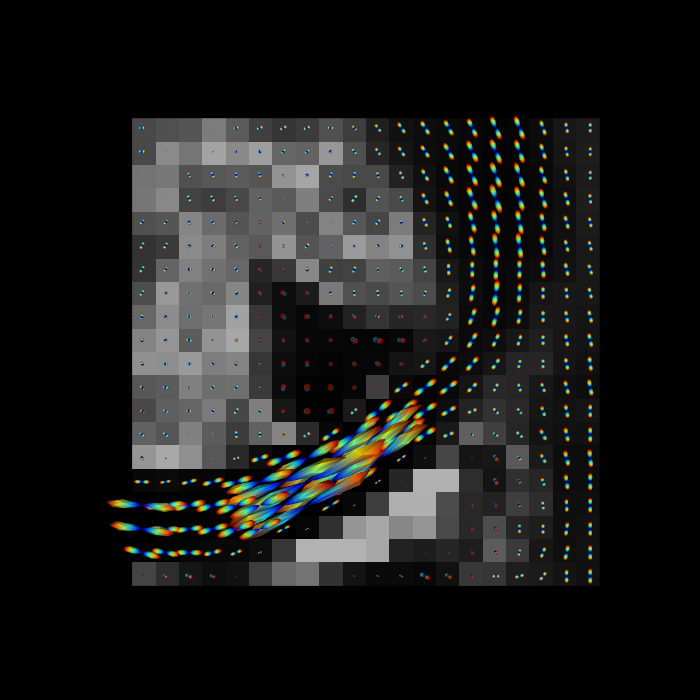

In [14]:
from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods[70:90,:, 70:90], sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, odi_im)
fvtk.record(ren=ren, size=[700, 700])

from IPython.display import Image
Image(filename='dipy.png', width=700)

You can see the corpus callosum coming in the from the left and joining the centrum semiovale on the right. The intensity of the background shows ODI of the Watson distribution (inversely related to concentration $\kappa$). Notice it is low in the corpus callosum and higher in non-white matter areas. Notice that NODDI-Watson cannot estimate crossings, which are expected in the centrum semiovale on the right. This biases any comparison/estimation of volume fractions and concentrations in these areas.

In [15]:
from os import remove
remove('dipy.png')

## Estimating Error Metrics: MSE and $R^2$

Whenever you fit a model, it's always wise to check out the error of the model fit. Here we estimate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination. In MSE the lower is better, while $R^2$ has an upper bound of one, which represents a perfect model fit.

/home/rutger/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/fitted_modeling_framework.py:123: RuntimeWarning: invalid value encountered in divide
  data_ = data / self.S0[..., None]
/home/rutger/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/fitted_modeling_framework.py:104: RuntimeWarning: invalid value encountered in divide
  data_ = data / self.S0[..., None]


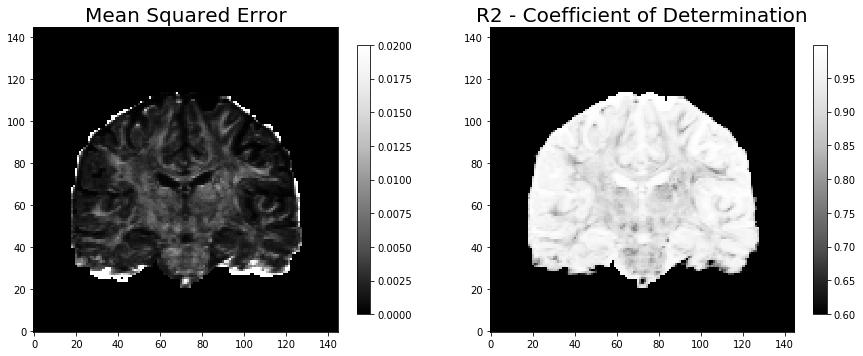

In [16]:
mse = NODDI_fit_hcp.mean_squared_error(data_hcp)
R2 = NODDI_fit_hcp.R2_coefficient_of_determination(data_hcp)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=0.02, cmap='Greys_r')
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=0.6, cmap='Greys_r')
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20);

Ideally, you want the MSE and $R^2$ to show no structure of the underlying data - which would mean the model can at least fit the data equally well everywhere. Instead, in NODDI-Watson we can see clearly see the structure of the different brain areas. This means that the model cannot fit the diffusion signal equally well in all brainn areas, and that interpretation of model parameters will be biased when comparing them between these different areas.

When doing these studies, ALWAYS verify whether differences in estimated parameters reflect actual tissue changes, or only reflect the limitations of the model itself.